<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/06_regression_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実データを単回帰分析

**参考書**

Laura Igual, Santi Seguí.<br/>
Introduction to Data Science: A Python Approach to Concepts, Techniques and Applications. Springer. 2017.
https://link.springer.com/book/10.1007%2F978-3-319-50017-1

# 海氷域面積と気候変動
北半球と南半球の海氷域面積を分析し、面積が減少傾向にあるのかどうかを調べてみる。

データは、下記の場所から取得。

https://nsidc.org/data/seaice_index/archives


「data」タブをクリックし、以下の2つのファイルをダウンロードしておく。
*   [北極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv)
*   [南極域の海氷域面積データ](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv)

<br/>
参考：半旬ごとにまとめたデータなら、気象庁の下記のページにある。
https://www.data.jma.go.jp/gmd/kaiyou/db/seaice/global/globe_area.html


### 1) データファイルを読み込んで前処理をする

In [0]:
import pandas as pd

In [82]:
# 北半球のデータを扱う（南半球のデータは自習）
n_ice = pd.read_csv('N_seaice_extent_daily_v3.0.csv')
print('shape:', n_ice.shape)
n_ice.head() 

shape: (13491, 6)


,Year,Month,Day,Extent,Missing,Source Data
0,YYYY,MM,DD,10^6 sq km,10^6 sq km,Source data product web sites: http://nsidc.o...
1,1978,10,26,10.231,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
2,1978,10,28,10.420,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
3,1978,10,30,10.557,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...
4,1978,11,01,10.670,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...


毎日のデータがあるわけではないことが分かる。

（例：1978年10月27日のデータはない。）

In [83]:
# 列名の文字列に空白がある
n_ice.columns

Index(['Year', ' Month', ' Day', '     Extent', '    Missing', ' Source Data'], dtype='object')

In [84]:
# 列名の空白を除去する
n_ice.columns = n_ice.columns.str.strip()
n_ice.columns

Index(['Year', 'Month', 'Day', 'Extent', 'Missing', 'Source Data'], dtype='object')

In [0]:
# 必要な列だけ残す
n_ice2 = n_ice[['Year', 'Month', 'Day', 'Extent']]

In [86]:
# 最初の行はデータのフォーマットの説明のようだ
n_ice2.head()

,Year,Month,Day,Extent
0,YYYY,MM,DD,10^6 sq km
1,1978,10,26,10.231
2,1978,10,28,10.420
3,1978,10,30,10.557
4,1978,11,01,10.670


In [87]:
# だから、最初の行は削除する
n_ice3 = n_ice2.iloc[1:,]
n_ice3.head()

,Year,Month,Day,Extent
1,1978,10,26,10.231
2,1978,10,28,10.420
3,1978,10,30,10.557
4,1978,11,01,10.670
5,1978,11,03,10.777


In [88]:
# 1979年と2020年はデータが完全でないので、削除する
n_ice4 = n_ice3.loc[(n_ice3['Year'] != '1978') & (n_ice3['Year'] != '2020'),]
n_ice4.head()

,Year,Month,Day,Extent
35,1979,01,02,14.997
36,1979,01,04,14.922
37,1979,01,06,14.929
38,1979,01,08,14.968
39,1979,01,10,15.190


In [89]:
n_ice4.tail()

,Year,Month,Day,Extent
13387,2019,12,27,12.764
13388,2019,12,28,12.729
13389,2019,12,29,12.800
13390,2019,12,30,12.912
13391,2019,12,31,12.949


In [90]:
# 数値化する（年月日は整数に。海氷域面積は浮動小数点数に。）
int_cols = ['Year', 'Month', 'Day']
cols_as_int = n_ice4[int_cols].astype(int)
#n_ice4[,int_cols] = cols_as_int
col_as_float = n_ice4['Extent'].astype(float)
#n_ice4['Extent'] = col_as_int
n_ice = pd.concat([cols_as_int, col_as_float], axis=1)
n_ice.head()

,Year,Month,Day,Extent
35,1979,1,2,14.997
36,1979,1,4,14.922
37,1979,1,6,14.929
38,1979,1,8,14.968
39,1979,1,10,15.190


In [91]:
# 行のindexを打ち直す
n_ice.reset_index(drop=True, inplace=True)
n_ice.head()

,Year,Month,Day,Extent
0,1979,1,2,14.997
1,1979,1,4,14.922
2,1979,1,6,14.929
3,1979,1,8,14.968
4,1979,1,10,15.190


In [92]:
# おかしな値がないかチェックする
# （欠測値が特殊な値で表されていたりするデータもあるため。）
n_ice.describe()['Extent']

count    13357.000000
mean        11.303127
std          3.286177
min          3.340000
25%          8.566000
50%         11.990000
75%         14.215000
max         16.635000
Name: Extent, dtype: float64

### 2) 一ヶ月ごとにデータをまとめて、平均をとる
これは、「同じ月の中での値の変動は、正規分布に従うノイズにすぎない」と、

仮定していることに相当する。

もちろん、このように仮定するのが正しいかどうかは、分からない。

In [0]:
n_ice_grouped = n_ice.groupby(['Year', 'Month'], as_index=False)

In [94]:
n_ice_monthly = n_ice_grouped.mean()[['Year', 'Month', 'Extent']]
n_ice_monthly.head()

,Year,Month,Extent
0,1979,1,15.414000
1,1979,2,16.175286
2,1979,3,16.341938
3,1979,4,15.446800
4,1979,5,13.856867


In [0]:
n_ice = n_ice_monthly

### 3) 一年間の範囲での変化のパターンを可視化する

In [0]:
# 可視化の準備
import numpy as np
import matplotlib.pylab as plt

plt.style.use('seaborn-whitegrid')
plt.rc('xtick', labelsize = 10) 
plt.rc('ytick', labelsize = 10) 
plt.rc('font', size = 12) 
plt.rc('figure', figsize = (12, 5))

Text(0, 0.5, 'Extent')

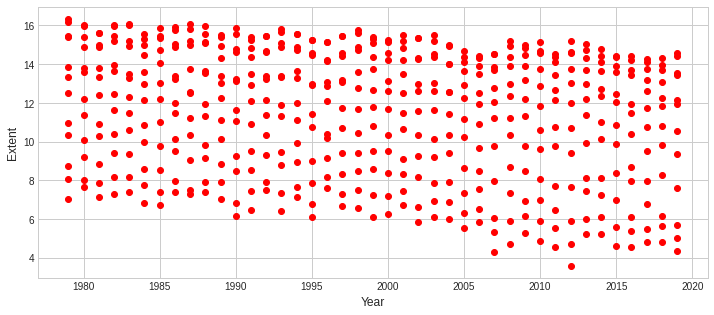

In [97]:
# 散布図を描いてみる。
# 横軸は年にして、同じ年のデータは同じ縦の位置にまとめてプロットする。
x = n_ice.Year
y = n_ice.Extent
plt.scatter(x, y, color = 'red')
plt.xlabel('Year')
plt.ylabel('Extent')

In [0]:
# seabornを使う準備
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2,'font.family': [u'times']})

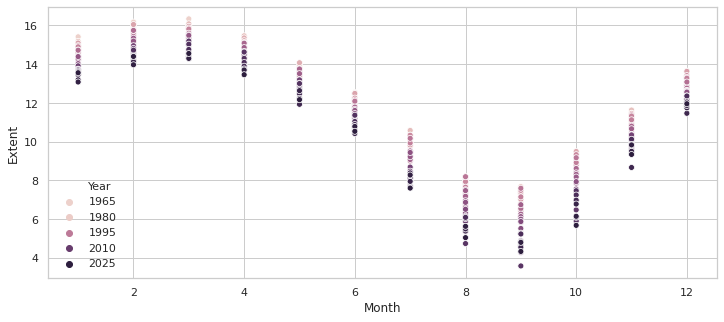

In [99]:
# seabornの散布図で、年の違いを横断して、各月ごとに可視化する。
# つまり、面積データに季節性があるかどうかを確認する。
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.savefig("IceExtentByMonth.png", dpi = 300, bbox_inches = 'tight')

一年間の間で、はっきりした周期的な変化パターンがあることがわかる。

つまり、「この月は、だいたいこのぐらい値」という値があることが分かる。

### 4) 一年間の範囲内に見られる変化パターンを取り除く

In [100]:
# 各月のデータの、すべての年にわたる平均と標準偏差を求める。
grouped = n_ice.groupby('Month')
month_means = grouped.Extent.mean()
month_stds = grouped.Extent.std()
print('Means:', month_means)
print('Standard deviations:',month_stds)

Means: Month
1     14.268192
2     15.129459
3     15.284289
4     14.564178
5     13.147218
6     11.581137
7      9.176441
8      6.857813
9      6.066433
10     7.976225
11    10.480825
12    12.672548
Name: Extent, dtype: float64
Standard deviations: Month
1     0.608141
2     0.604162
3     0.559459
4     0.544620
5     0.511909
6     0.611717
7     0.903896
8     1.008838
9     1.117111
10    1.100451
11    0.716940
12    0.592981
Name: Extent, dtype: float64


この計算は、「同じ月であれば、年が変わっても、

面積データの変動は正規分布で表現できる」と仮定した上で、行っている。

この仮定が正しいかどうかは、分からない。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1ae43a3c8>,
      dtype=object)

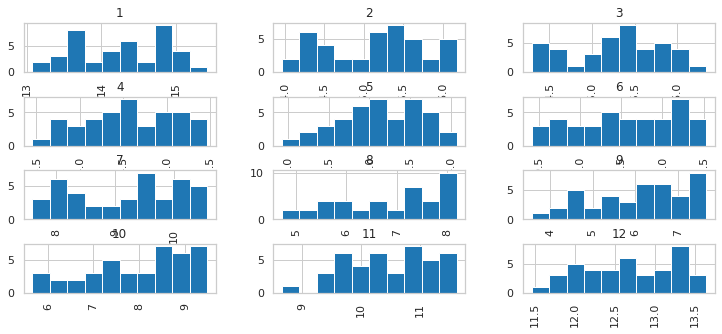

In [101]:
# 試みに、ヒストグラムを月別に描いてみる。
n_ice.Extent.hist(by=n_ice_monthly.Month)

In [102]:
# 月ごとにz値へ変換する。（よく使うデータ標準化の手法。）
for i in range(1, 13):
  idx = n_ice.Month == i
  z_values = (n_ice.Extent[idx] - month_means[i]) / month_stds[i]
  n_ice.Extent[idx] = z_values

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


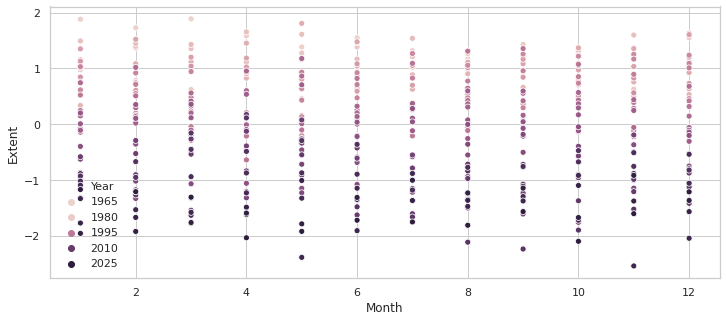

In [103]:
sns.scatterplot(x="Month", y="Extent", hue="Year", data=n_ice)
plt.savefig("IceExtentZscoreByMonth.png", dpi = 300, bbox_inches = 'tight')

In [104]:
print('mean:', n_ice.Extent.mean())
print('std:', n_ice.Extent.std())

mean: -9.919797594008513e-16
std: 0.9887349196545032


### 5) 1979年〜2019年の全範囲での変化の様子を見る

「この月のデータは、平均的にはだいたいいくらで、

すべての年に渡って調べるとバラツキはいくらぐらい」

という意味での、各月の個性は、すでに消した。

その上で、1979年から2019年まで、全範囲での面積の変化の傾向を見る。

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


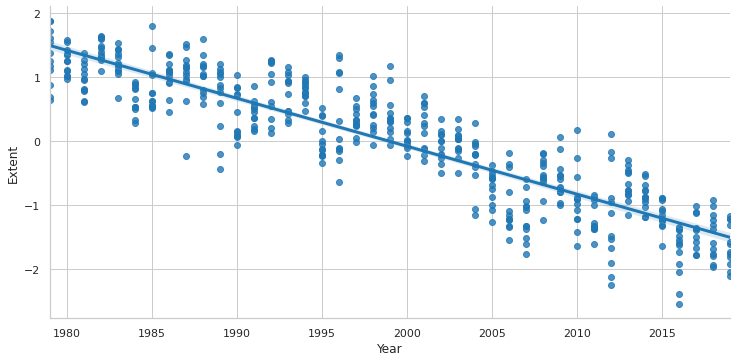

In [105]:
# seabornの単回帰のプロットを利用する。
sns.lmplot("Year", "Extent", n_ice, size = 5.2, aspect = 2);
plt.savefig("IceExtentAllMonthsByYearlmplot.png", dpi = 300, bbox_inches = 'tight')

*   直線でfittingしても、悪くなさそう。
*   そして、面積減少の傾向が見て取れる。



/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


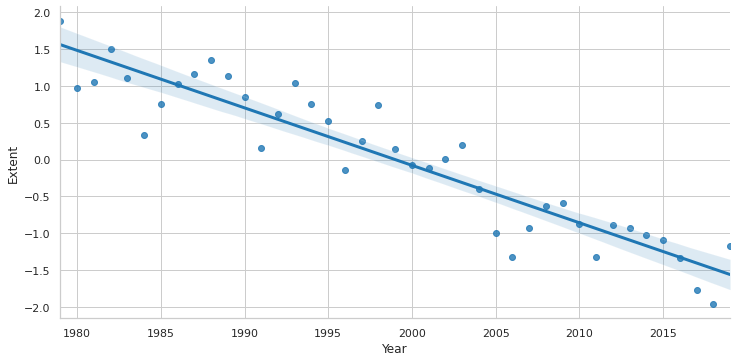

In [106]:
# 1月のみで、lmplotを使う。
jan = n_ice[n_ice.Month == 1];
sns.lmplot("Year", "Extent", jan, size = 5.2, aspect = 2);

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


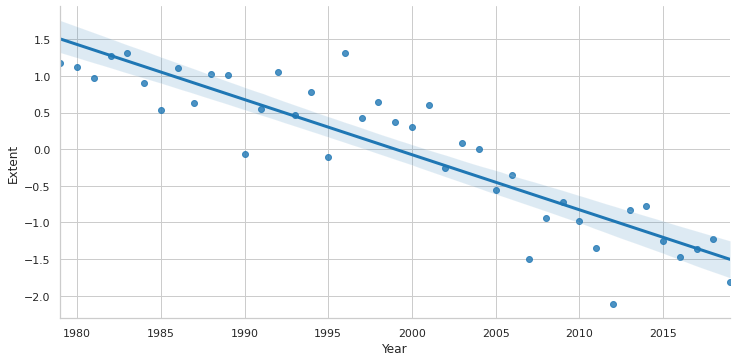

In [107]:
# 同様に、元のデータ（iceのこと。）の戻って、今度は8月のみで、lmplotを使う。
aug = n_ice[n_ice.Month == 8]
sns.lmplot("Year", "Extent", aug,size = 5.2, aspect = 2);

In [108]:
# ピアソンの相関係数と、無相関の検定のp値を求める。
import scipy.stats
scipy.stats.pearsonr(n_ice.Year.values, n_ice.Extent.values)

(-0.8978279138240126, 1.154895205068565e-176)

### 6) sklearnの線形回帰を使った分析
以上は、exploratoryな分析。
ここからは、機械学習。

In [109]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()

x = n_ice[['Year']]
y = n_ice[['Extent']]

reg.fit(x, y)

print('Coefficients:', reg.coef_)
print('Intercept:', reg.intercept_)

Coefficients: [[-0.07494923]]
Intercept: [149.82350308]


フィッティングの評価

*   mean squared error ($MSE$)
*   the coefficient of determination ($R^2$)

$R^2$は$(1 - \textbf{u}/\textbf{v})$と定義される。

$\textbf{u}$ は残差の二乗和 $\sum (\textbf{y} - \hat{\textbf{y}})^2$。（$\hat{\textbf{y}}$が回帰による予測値。）

$\textbf{v}$ は、真値の平均$\bar{\textbf{y}}$ からの個々の真値$\textbf{y}$のズレ$(\textbf{y} - \bar{\textbf{y}})$の二乗和$\sum (\textbf{y} - \bar{\textbf{y}})^2$。

つまり、$R^2$は、平均からのズレのうち、回帰によって説明されない部分が占める割合。

$R^2$の最も良い値は1.0。これより小さくなるほど悪くなる。

MSE: 0.18917564600821546
R^2: 0.7594513722367365
var: Extent    0.977597
dtype: float64


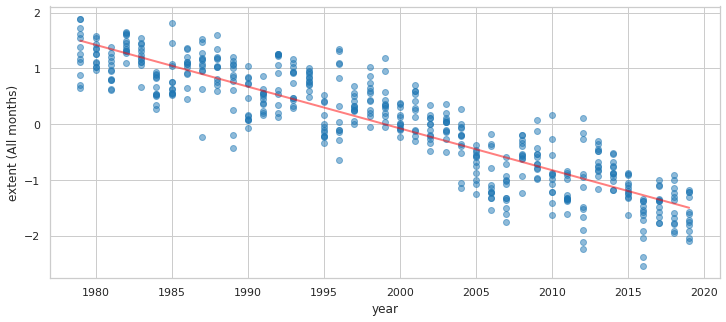

In [110]:
from sklearn import metrics

# Analysis for all months together.
x = n_ice[['Year']]
y = n_ice[['Extent']]
model = LinearRegression()
model.fit(x, y)
y_hat = model.predict(x)
plt.plot(x, y,'o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)
plt.xlabel('year')
plt.ylabel('extent (All months)')
print("MSE:", metrics.mean_squared_error(y_hat, y))
print("R^2:", metrics.r2_score(y_hat, y))
print("var:", y.var())
plt.savefig("IceExtentLinearRegressionAllMonthsByYearPrediction.png", dpi = 300, bbox_inches = 'tight')

どうやら、データは長期的なnegative trendを示している、と言ってもよさそう。


MSE: 0.12696890716443168
R^2: 0.8503855814576322


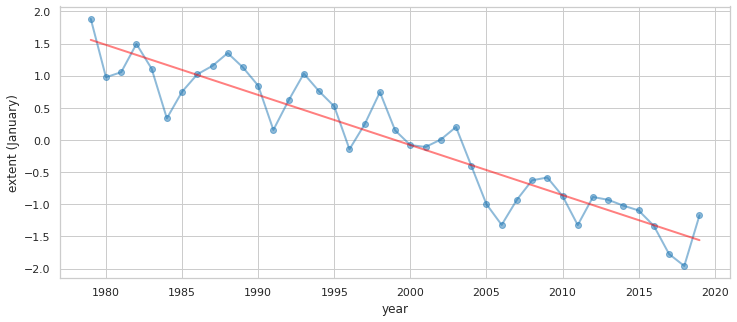

In [112]:
# 1月だけで分析。
x = jan[['Year']]
y = jan[['Extent']]

model = LinearRegression()
model.fit(x, y)

y_hat = model.predict(x)

plt.figure()
plt.plot(x, y,'-o', alpha = 0.5)
plt.plot(x, y_hat, 'r', alpha = 0.5)
plt.xlabel('year')
plt.ylabel('extent (January)')

print("MSE:", metrics.mean_squared_error(y_hat, y))
print("R^2:", metrics.r2_score(y_hat, y))

### 7) 予測
機械学習ならでは。

2025年の値を予測してみる。

In [115]:
X = [[2025]]
y_hat = model.predict(X)
j = 1 # January
# Original value (before normalization)
y_hat = y_hat * month_stds[j] + month_means[j]
print("Prediction of extent for January 2025 (in millions of square km):", y_hat)

Prediction of extent for January 2025 (in millions of square km): [[13.03714208]]


# 課題6

南極海氷域について、全く同様に、分析をしてみよう。

.ipynbファイルをBlackboardに提出してください。